# Multi-output Gaussian processes in GPflow

This notebook shows how to construct a multi-output GP model using GPflow. We will consider a regression problem for functions $f: \mathbb{R}^D \rightarrow \mathbb{R}^P$. We assume that the dataset is of the form $(X, f_1), \dots, (X, f_P)$, that is, we observe all the outputs for a particular input location (for cases where there are **not** fully observed outputs for each input, see [A simple demonstration of coregionalisation](./coregionalisation.ipynb)).

Here we assume a model of the form: 
$$f(x) = W g(x),$$
where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$. We assume that the outputs of $g$ are uncorrelated, and that by *mixing* them with $W$ they become correlated. In this notebook, we show how to build this model using Sparse Variational Gaussian Process (SVGP) for $g$, which scales well with the numbers of data points and outputs. 

Here we have two options for $g$:
1. The output dimensions of $g$ share the same kernel.
2. Each output of $g$ has a separate kernel.


In addition, we have two further suboptions for the inducing inputs of $g$:
1. The instances of $g$ share the same inducing inputs.
2. Each output of $g$ has its own set of inducing inputs.

The notation is as follows:
$$
\newcommand{\GP}{\mathcal{GP}}
\newcommand{\NN}{\mathcal{N}}
\newcommand{\LL}{\mathcal{L}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\EE}{\mathbb{E}}
\newcommand{\valpha}{\boldsymbol\alpha}
\newcommand{\vf}{\mathbf{f}}
\newcommand{\vF}{\mathbf{F}}
\newcommand{\vg}{\mathbf{g}}
\newcommand{\vW}{\mathbf{W}}
\newcommand{\vI}{\mathbf{I}}
\newcommand{\vZ}{\mathbf{Z}}
\newcommand{\vu}{\mathbf{u}}
\newcommand{\vU}{\mathbf{U}}
\newcommand{\vX}{\mathbf{X}}
\newcommand{\vY}{\mathbf{Y}}
\newcommand{\identity}{\mathbb{I}}
$$
- $X \in \mathbb{R}^{N \times D}$ denotes the input
- $Y \in \RR^{N \times P}$ denotes the output
- $k_{1..L}$, $L$ are kernels on $\RR^{N \times D}$
- $g_{1..L}$, $L$ are independent $\GP$s  with $g_l \sim \GP(0,k_l)$
- $f_{1..P}$, $P$ are correlated  $\GP$s  with $\vf = \vW \vg$ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gpf

import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf
%matplotlib inline

MAXITER = gpf.test_util.notebook_niter(15000)

## Generate synthetic data
We create a utility function to generate synthetic data. We assume that:

In [2]:
N = 100 # number of points
D = 1  # number of input dimensions
M = 20  # number of inducing points
L = 2  # number of latent GPs
P = 3  # number of observations = output dimensions

In [3]:
def generate_data(N=100):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs = N x D
    G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X)) # G = N x L
    W = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])  # L x P
    F = np.matmul(G, W)  # N x P
    Y = F + np.random.randn(*F.shape) * [0.2, 0.2, 0.2]
    
    return X, Y

In [4]:
X, Y = generate_data(N)

We create a utility function for plotting:

In [5]:
def plot_model(m, lower=-6, upper=6):
    pX = np.linspace(lower, upper, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(m.X.value, m.Y.value, 'x')
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
    plt.xlabel('X')
    plt.ylabel('f')

## Model the outputs $f(x)$ directly
The three examples below show how to model the outputs of the model $f(x)$ directly. Mathematically, this case is equivalent to having:
$$
f(x) = I g(x),
$$
i.e. $W = I$ and $P = L$.

### 1. Shared independent MultiOutputKernel (MOK) and shared independent features

We will use the same kernel to model each of the output dimensions, and the same inducing inputs in each of the approximations.

Because we are building more than one model in this notebook, it is a good practice to reset the default TensorFlow graph and session so that we do not increase the size of the graph unnecessarily and do not accidentally overwrite tensors. For more information, see [Handling TensorFlow graphs and sessions](../understanding/tf_graphs_and_sessions.ipynb).

In [6]:
gpf.reset_default_graph_and_session()

In [7]:
# create multioutput kernel
kernel = mk.SharedIndependentMok(gpf.kernels.RBF(1) + gpf.kernels.Linear(1), output_dimensionality=P) 
# initialisation of inducing input locations (M random points from the training inputs)
Z = X[:M,...].copy() 
# create multioutput features from Z
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(Z)) 

In [8]:
# create SVGP model as usual and optimise
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature) 

opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 30.250613
  Number of iterations: 8710
  Number of functions evaluations: 9327


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 30.250613
  Number of iterations: 8710
  Number of functions evaluations: 9327


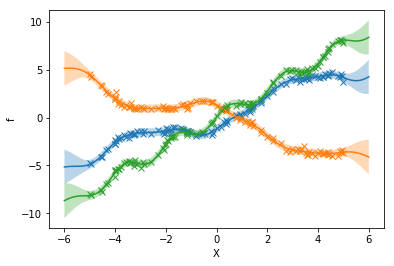

In [9]:
# Plot predictions and observations
plot_model(m)

### 2. Separate independent MultiOutputKernel (MOK) and shared independent features

In [10]:
gpf.reset_default_graph_and_session()

In [11]:
# Create list of kernels for each output
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
# Create multioutput kernel from kernel list
kernel = mk.SeparateIndependentMok(kern_list)
# initialisation of inducing input locations (M random points from the training inputs)
Z = X[:M,...].copy() 
# create multioutput features from Z
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(Z)) 

In [12]:
# create SVGP model as usual and optimise
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 28.645695
  Number of iterations: 5750
  Number of functions evaluations: 6115


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 28.645695
  Number of iterations: 5750
  Number of functions evaluations: 6115


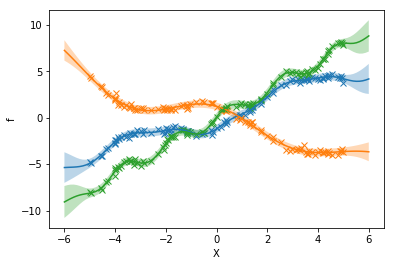

In [13]:
plot_model(m)

### 3. Separate independent kernel and separate independent features

In [14]:
gpf.reset_default_graph_and_session()

In [15]:
# Create list of kernels for each output
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
# Create multioutput kernel from kernel list
kernel = mk.SeparateIndependentMok(kern_list)
# initialisation of inducing input locations, one set of locations per output
Zs = [X[np.random.permutation(len(X))[:M],...].copy() for _ in range(P)]
# initialise as list inducing features
feature_list = [gpf.features.InducingPoints(Z) for Z in Zs]
# create multioutput features from feature_list
feature = mf.SeparateIndependentMof(feature_list)

**NOTE:** While the inducing points are independent, there needs to be the same number of inducing points per dimension.

In [16]:
# create SVGP model as usual and optimise
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 28.645250
  Number of iterations: 13090
  Number of functions evaluations: 13895


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 28.645250
  Number of iterations: 13090
  Number of functions evaluations: 13895


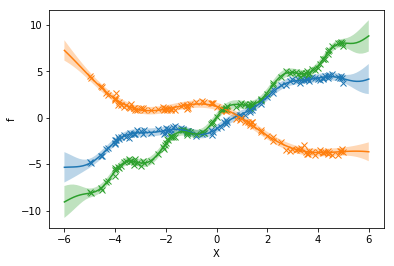

In [17]:
plot_model(m)

The plot below shows that we use different inducing *inputs* in each output dimension.

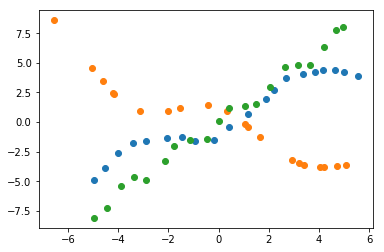

In [18]:
for i in range(len(m.feature.feat_list)):
    q_mu_unwhitened, q_var_unwhitened = m.predict_f(m.feature.feat_list[i].Z.value)
    plt.plot(m.feature.feat_list[i].Z.value, q_mu_unwhitened[:, [i]], "o")

## Model $f(x)$ by doing inference in the $g$ space
### Mixed kernel and uncorrelated features 

Remember the general case: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$, where $L \leq P$.
We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated.
With this setup we perform the optimal routine to calculate the conditional. Namely, calculate the conditional of the uncorrelated latent $g$ and afterwards project the mean and variance using the mixing matrix: $\mu_f = W \mu_g$ and $\Sigma_f = W\Sigma_g W^\top$

- $ K_{uu} = L \times M \times M $
- $ K_{uf} = L \times M \times N $

In [19]:
gpf.reset_default_graph_and_session()

In [20]:
# Create list of kernels for each output
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
# Create multioutput kernel from kernel list
kernel = mk.SeparateMixedMok(kern_list, W=np.random.randn(P, L)) # Notice that we initialise the mixing matrix W
# initialisation of inducing input locations (M random points from the training inputs)
Z = X[:M,...].copy()
# create multioutput features from Z
feature = mf.MixedKernelSharedMof(gpf.features.InducingPoints(Z))

In [21]:
# initialise mean of variational posterior to be of shape MxL
q_mu = np.zeros((M, L)) 
# initialise \sqrt(Σ) of variational posterior to be of shape LxMxM
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0 

# create SVGP model as usual and optimise
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature, q_mu=q_mu, q_sqrt=q_sqrt)

opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
  Objective function value: -8.103119
  Number of iterations: 13283
  Number of functions evaluations: 15001


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
  Objective function value: -8.103119
  Number of iterations: 13283
  Number of functions evaluations: 15001


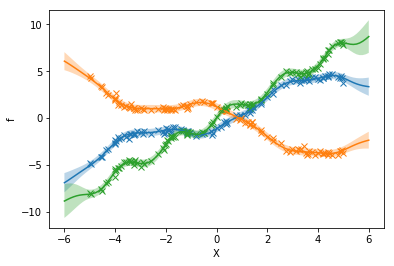

In [22]:
plot_model(m)

## Illustration of GPflow's multi-output capabilities

### Multi-output kernels (MOK) class diagram
![Multioutput kernels](./multioutput_kernels.svg)

### Multi-output features (MOF) class diagram
![Multioutput features](./multioutput_features.svg)

**NOTE:** `MixedKernelSeparateMof` is not implemented, but can easily be added to the framework.

The shape of Kuu and Kuf and the underlying conditional code depends on the Mof and Mok classes used.

| Feature                | Kernel                        | Kuu           | Kuf           | conditional                     | note                                                                                                                                                                                                            |
|------------------------|-------------------------------|---------------|---------------|---------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| InducingPoints         | Mok  | MxPxMxP | MxPxNxP | fully_correlated_conditional    | This is the default. For certain kernels this is very inefficient. In this case q_mu and q_sqrt are 1 x MP and 1 x MP x MP                                                                                                                                              |
| SharedIndependentMof   | SharedIndependentMok          | M x M         | M x N         | base_conditional                | These two classes are in a sense redundant, because we can achieve the same behaviour by using the single output Kernel and InducingFeature classes. They are added for illustrative purposes. Thanks to the conditional dispatch, the most efficient code path is used.                          |
| SeparateIndependentMof | SharedIndependentMok          | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                       |
| SharedIndependentMof   | SeparateIndependentMok        | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                                                                 |
| SeparateIndependentMof | SeparateIndependentMok        | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                                                                |
| SharedIndependentMof   | SeparateMixedKernel           | L x M x M     | M x L x N x P | independent_interdomain_conditional | Inducing outputs live in g-space                                                                                                                                                                                |
| SeparateIndependentMof | SeparateMixedKernel           | L x M x M     | M x L x N x P | independent_interdomain_conditional | Very similar to the above                                                                                                                                                                                           |
| MixedKernelSharedMof   | SeparateMixedKernel           | L x M x M     | L x M x N     | base_conditional                 | This is the most efficient implementation for MixedKernels.  The inducing outputs live in g-space. Here we use the output of the base conditional and project the mean and covariance with the mixing matrix W. |